# Feature selection

Feature selection is an important task while building any machine learning task. Adding relevant feature to the model makes it more explainable and accurate.

# Three broad categories for feature selection

1. Filter Method 
1. Wrapper Method 
1. Embedded Method

# Filter Method

We select a subset for feature for building model. Selection is based on some statistical criteria like information gain, chi-square and correlation coefficient scores.

Let download California housing dataset and assume we are building linear model for predicting average house price.

In [4]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
%matplotlib inline

In [5]:
house = datasets.california_housing.fetch_california_housing()

In [6]:
house.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [7]:
cali_house_df = pd.DataFrame(house.data, columns=house.feature_names)
# in units of 100,000.
cali_house_df['avg_house_val'] = house.target
cali_house_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,avg_house_val
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


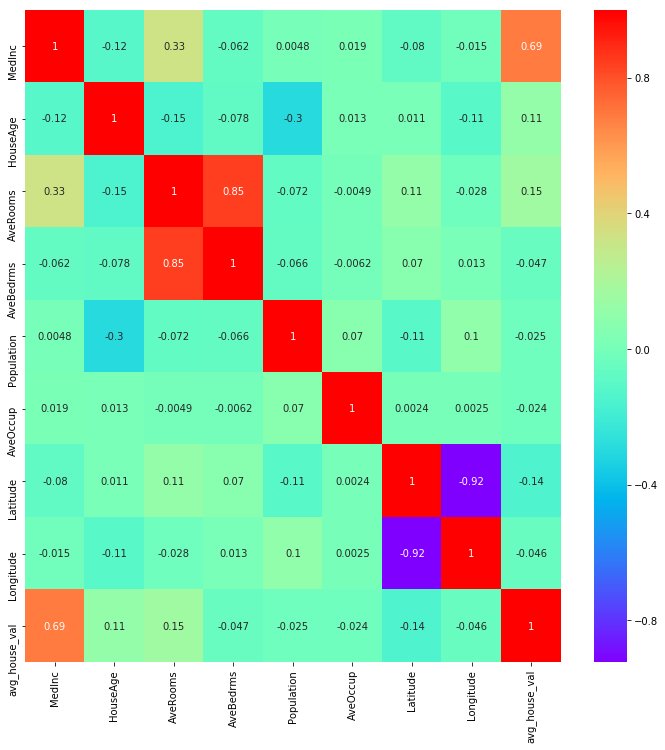

In [8]:
plt.figure(figsize=(12,12))
corr = cali_house_df.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.rainbow)
plt.show()

# We'll select variable with high correlation(> 0.6) to avg_house_price

In [9]:
selected_feat = abs(corr['avg_house_val'])>0.5
selected_feat

MedInc            True
HouseAge         False
AveRooms         False
AveBedrms        False
Population       False
AveOccup         False
Latitude         False
Longitude        False
avg_house_val     True
Name: avg_house_val, dtype: bool

# Wrapper methods.
Uses a machine learning algorithm performance as feature selection criteria.

- Backward Elimination
- Forward Selection
- Bidirectional Elimination
- RFE


## Backward Elimination

Starts with all the features and prunes feature based on some metric.

In [10]:
X = cali_house_df.drop('avg_house_val' ,axis=1)
X_with_const = sm.add_constant(X)
y = cali_house_df['avg_house_val']

/media/psnegi/psn/du/teaching/teach_2019/data_science_tools2/dst2_env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [11]:
model = sm.OLS(y,X_with_const).fit()
model.pvalues

const          0.000000e+00
MedInc         0.000000e+00
HouseAge       3.505485e-98
AveRooms       1.026311e-73
AveBedrms     6.725726e-115
Population     4.024472e-01
AveOccup       8.303694e-15
Latitude       0.000000e+00
Longitude      0.000000e+00
dtype: float64

Only select features with pval < 0.05

Populations has pval > 0.05, hence we'll eliminate it.

This is an iterative process.

In [12]:
columns = list(X.columns)
while len(columns) > 0:
    X_temp = X[columns]
    X_temp_with_const = sm.add_constant(X_temp)
    lr = sm.OLS(y, X_temp_with_const).fit()
    if lr.pvalues.max() > 0.05:
        print(lr.pvalues)
        columns.remove(lr.pvalues.idxmax())
    else:
        print('all pvalues < 0.05')
        break
    
print(columns)    

const          0.000000e+00
MedInc         0.000000e+00
HouseAge       3.505485e-98
AveRooms       1.026311e-73
AveBedrms     6.725726e-115
Population     4.024472e-01
AveOccup       8.303694e-15
Latitude       0.000000e+00
Longitude      0.000000e+00
dtype: float64
all pvalues < 0.05
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude']


 # RFE (Recursive Feature Elimination)

Recursively remove the features with less importance to  build the model.
In sklearn Importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute.

In [13]:
lr = LinearRegression()
rfe = RFE(lr, 6)

In [15]:
X_rfe= rfe.fit_transform(X,y)
lr.fit(X_rfe, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [16]:
print(rfe.ranking_)
print(rfe.support_)

[1 1 1 1 3 2 1 1]
[ True  True  True  True False False  True  True]


# But how do we know optimal number of features

In [18]:
no_of_features = np.arange(1, len(X.columns))

In [19]:
max_score =0
optimal_feature = 1
for current_feat_no in no_of_features:
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
    lr = LinearRegression()
    rfe = RFE(lr, current_feat_no)
    X_rfe= rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    lr.fit(X_rfe, y_train)
    score = lr.score(X_test_rfe,y_test)
    print('Optimal no of features are {} and score {}'.format(current_feat_no, score))       
    if score > max_score:
        optimal_feature= current_feat_no
        max_score = score
        
print('Optimal no of features are {} and score {}'.format(optimal_feature, max_score))        

Optimal no of features are 1 and score 0.0012984715729211782
Optimal no of features are 2 and score 0.24132214676452413
Optimal no of features are 3 and score 0.5667404462127066
Optimal no of features are 4 and score 0.5720072080584462
Optimal no of features are 5 and score 0.5820979355218483
Optimal no of features are 6 and score 0.5919342869002975
Optimal no of features are 7 and score 0.5944716307363294
Optimal no of features are 7 and score 0.5944716307363294


One should also use some threshold to decide if score change and increase in number of variable is justified.

or one can use cross validation wrapper

In [20]:

clf = LinearRegression()
trans = RFECV(clf)
X_trans = trans.fit_transform(X, y)

/media/psnegi/psn/du/teaching/teach_2019/data_science_tools2/dst2_env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [21]:
trans.support_

array([ True,  True,  True,  True, False,  True,  True,  True])

# Embedded Method


Search of feature is guided by the learning process. Regularization methods are the most common method for embedding methods.




Regularization idea:  Add a penalty(cost) against the complexity to reduce over fitting in the model.




regularized cost = model cost + regularization term

- [L1 LASSO](https://en.wikipedia.org/wiki/Lasso_\(statistics\)) (least absolute shrinkage and selection operator;)
 For linear regression
 
    regularied cost= MSE + $\alpha* l_1$ norm of coefficient

In [22]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: {}".format(reg.alpha_))
print("Best score using built-in LassoCV: {}".format(reg.score(X,y)))
reg.coef_

Best alpha using built-in LassoCV: 0.03221092661065104
Best score using built-in LassoCV: 0.5902088471774518


/media/psnegi/psn/du/teaching/teach_2019/data_science_tools2/dst2_env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([ 3.81485543e-01,  1.12872676e-02,  2.20440782e-03,  0.00000000e+00,
        1.88778147e-06, -3.51349405e-03, -3.39002345e-01, -3.39456784e-01])

Text(0.5, 1.0, 'Lasso regularized model Model')

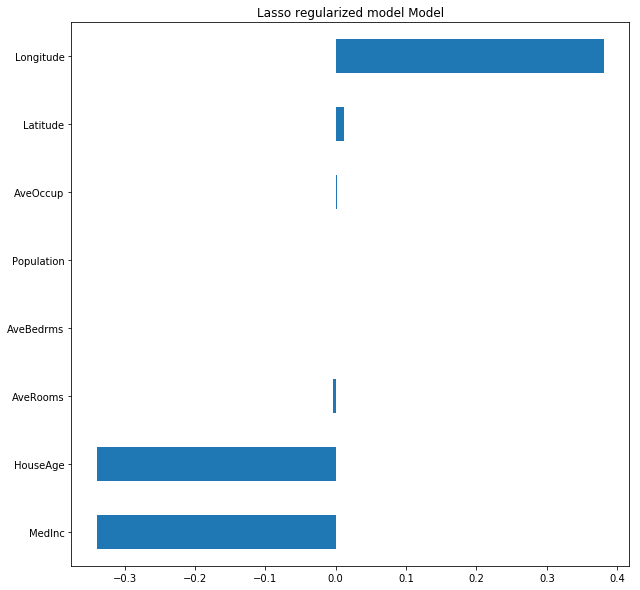

In [24]:
coef = pd.Series(reg.coef_, index = X.columns)
coef = coef.sort_values()
coef.plot(kind = "barh", figsize = (10,10))
plt.title("Lasso regularized model Model")

# sklearn  SelectFromModel
It  is a meta-transformer that can be used along with any estimator that has a coef_ or feature_importances_ attribute after fitting. 

In [1]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
iris = load_iris()
X, y = iris.data, iris.target
X.shape
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape        

(150, 2)

# sklearn  removing features with low variance
Removes all features whose variance doesn’t meet some threshold.

In [26]:
# Boolean features example from sklearn
from sklearn.feature_selection import VarianceThreshold
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

 Can use dimensionality reduction techniques if too may features